<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/Amazon_Cell_Phone_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libraries

In [2]:
from __future__ import print_function

import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

# Sentiment Analysis
import textblob as tb

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

## File Upload
Upload all the required files.  
**reviews.csv**: all available reviews  
**items.csv**: all phones available  

In [5]:
# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

In [0]:
reviews.head(1)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0


In [0]:
items.head(1)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


# Exploratory Data Analysis

## Items Dataset
We have **720 phone models** and **10 features**.  
*rating*, *totalReviews*, *price* and *originalPrice* are **numerical**.  
All other features are **strings**.   

No significant NA's in this dataset.  

**Samsung** has the highest # of phones with 346, followed by **Motorola** having 105 and **Apple** has 63 phones.  

**Xiaomi** has the best rating of 4.4/5 followed by **HUAWEI** and then **ASUS**.

In [0]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [0]:
items.shape

(720, 10)

In [0]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [0]:
item_brand = items.groupby('brand').agg({'asin':['count'], 'rating':['mean'], 'totalReviews':['sum']})
item_brand.columns = ['count_phone', 'avg_rating', 'total_reviews']
item_brand.sort_values(by="count_phone", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Samsung,346,3.632659,37701
Motorola,105,3.643810,9419
Apple,63,3.782540,6315
Xiaomi,46,4.415217,5574
Nokia,44,3.386364,6182
Google,38,3.771053,4238
HUAWEI,32,4.021875,2467
Sony,27,3.788889,3312
OnePlus,10,3.580000,406


In [0]:
item_brand.sort_values(by="avg_rating", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Xiaomi,46,4.415217,5574
HUAWEI,32,4.021875,2467
ASUS,5,3.860000,263
Sony,27,3.788889,3312
Apple,63,3.782540,6315
Google,38,3.771053,4238
Motorola,105,3.643810,9419
Samsung,346,3.632659,37701
OnePlus,10,3.580000,406


## Reviews Dataset
We have **67986 reviews** with **8 features**.  
*rating* and *helpfulVotes* are **numerical**.  
All other features are **strings**.

*helpfulVotes* has a lot of NA's.  
The other features have very few NA's.  

40% of the reviews are for **Samsung**.

In [0]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [0]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [0]:
reviews.shape

(67986, 8)

## Merged Dataset

The dataset pulled atleast 80% of data available at that time per brand. **Samsung**, **Motorola** and **Nokia** have 90+% data.  

The highest deviation in ratings due to missing reviews is for OnePlus phones at 0.63. **Samsung**, **Motorola**, **Nokia** and **Apple** have less than 0.2 rating deviation.  

We see a bi-modal distribution of ratings for all the brands which is also representative of the plot with all brands combined.  



In [0]:
# Create a merged dataframe
df = pd.merge(reviews, items, on='asin')

# Find brand-wise summary
df_brand = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
df_brand.columns = ['brand', 'reviews', 'avg_avlb_rating']
df_brand = df_brand.sort_values(by='reviews',ascending=False)
brand_summary = pd.merge(df_brand, item_brand, on='brand')
brand_summary['data_ratio'] = brand_summary['reviews']/brand_summary['total_reviews']
brand_summary['rating_dev'] = brand_summary['avg_avlb_rating'] - brand_summary['avg_rating']
brand_summary

,brand,reviews,avg_avlb_rating,count_phone,avg_rating,total_reviews,data_ratio,rating_dev
0,Samsung,33629,3.781736,346,3.632659,37701,0.891992,0.149077
1,Motorola,8880,3.818694,105,3.643810,9419,0.942775,0.174884
2,Nokia,5915,3.584446,44,3.386364,6182,0.956810,0.198083
3,Apple,5145,3.701263,63,3.782540,6315,0.814727,-0.081276
4,Xiaomi,4411,4.371344,46,4.415217,5574,0.791353,-0.043873
5,Google,3787,3.584896,38,3.771053,4238,0.893582,-0.186157
6,Sony,3196,3.786921,27,3.788889,3312,0.964976,-0.001968
7,HUAWEI,2225,4.240899,32,4.021875,2467,0.901905,0.219024
8,OnePlus,347,4.213256,10,3.580000,406,0.854680,0.633256
9,ASUS,251,3.721116,5,3.860000,263,0.954373,-0.138884


In [0]:
brand_rating = pd.pivot_table(df, values='asin', index=['brand'], columns=['rating_x'], aggfunc='count')
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,41,23,25,38,124
Apple,1191,243,322,545,2844
Google,883,286,267,435,1916
HUAWEI,246,63,124,268,1524
Motorola,1562,542,653,1310,4813
Nokia,1253,457,540,910,2755
OnePlus,46,6,13,45,237
Samsung,6646,1891,2292,4128,18672
Sony,511,259,280,496,1650


In [0]:
brand_rating = brand_rating.div(brand_rating.sum(axis=1), axis=0)
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,0.163347,0.091633,0.099602,0.151394,0.494024
Apple,0.231487,0.047230,0.062585,0.105928,0.552770
Google,0.233166,0.075522,0.070504,0.114867,0.505941
HUAWEI,0.110562,0.028315,0.055730,0.120449,0.684944
Motorola,0.175901,0.061036,0.073536,0.147523,0.542005
Nokia,0.211834,0.077261,0.091293,0.153846,0.465765
OnePlus,0.132565,0.017291,0.037464,0.129683,0.682997
Samsung,0.197627,0.056231,0.068155,0.122751,0.555235
Sony,0.159887,0.081039,0.087610,0.155194,0.516270


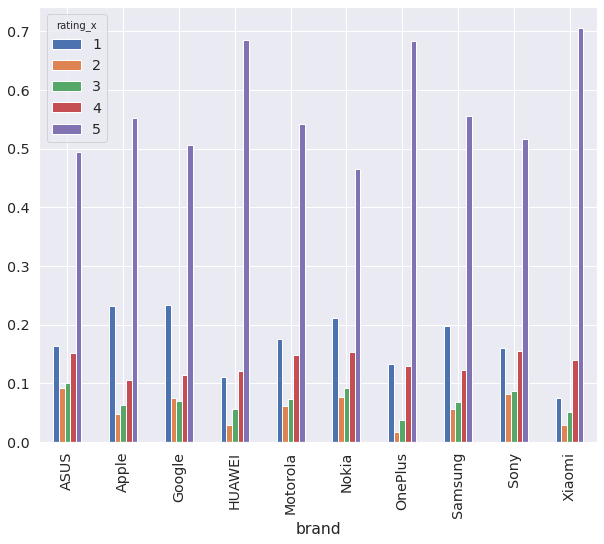

In [0]:
brand_rating.plot(kind='bar', figsize=(10,8))

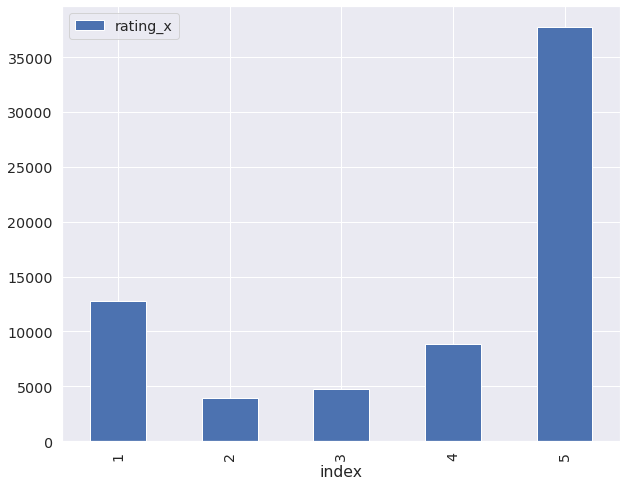

In [0]:
pd.DataFrame(df['rating_x'].value_counts()).reset_index().sort_values(by="index").plot(kind="bar", x="index", figsize=(10,8))

## Cleaning

In [0]:
df_reviews = df[['body', 'brand']].reset_index()
df_reviews['body'] = df_reviews['body'].fillna("")
df_reviews['word_count'] = 0
df_reviews['most_common'] = ""
df_reviews['common_count'] = 0

In [0]:
df_reviews.tail()

,index,body,brand,word_count,most_common,common_count
67981,67981,I love the camera on this phone. The screen is...,Sony,0,,0
67982,67982,I've been an Xperia user for several years and...,Sony,0,,0
67983,67983,buy one more for my cousin,Sony,0,,0
67984,67984,Product looks and works like new. Very much re...,Apple,0,,0
67985,67985,I love the size and style of this phone. It is...,Samsung,0,,0


In [0]:
stop_words = set(stopwords.words("english"))
for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub('\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    #Compute number of words
    df_reviews.iloc[i,3] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,5] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,4] = ""
        df_reviews.iloc[i,5] = 0

In [0]:
df_reviews.head()

,index,body,brand,word_count,most_common,common_count
0,0,I had the Samsung A600 for awhile which is abs...,NaN,166,phone,7
1,1,Due to a software issue between Nokia and Spri...,NaN,68,sprint,3
2,2,"This is a great, reliable phone. I also purcha...",NaN,69,phone,3
3,3,"I love the phone and all, because I really did...",NaN,44,phone,5
4,4,The phone has been great for every purpose it ...,NaN,57,get,5


In [0]:
df_reviews['word_count'].mean()

28.143558968022827

In [0]:
df_reviews['sentiment'] = 0
df_reviews['pos'] = 0
df_reviews['neg'] = 0
for i in range(df_reviews.shape[0]):
  #Pick a review
  rev = df_reviews.iloc[i,1]
  df_reviews.iloc[i,6] = tb.TextBlob(rev).sentiment.polarity
  df_reviews.iloc[i,7] = df_reviews.iloc[i,5] > 0
  df_reviews.iloc[i,8] = df_reviews.iloc[i,6] < 0

df_reviews

In [0]:
df_reviews.groupby('brand').agg({'sentiment':['mean'], 'pos':['count'], 'neg':['count']}).reset_index()

,brand,sentiment
,,mean
0,ASUS,0.253001
1,Apple,0.238408
2,Google,0.243897
3,HUAWEI,0.301263
4,Motorola,0.271063
5,Nokia,0.237997
6,OnePlus,0.294085
7,Samsung,0.276568
8,Sony,0.268844


In [0]:
top_words = df_reviews.groupby('most_common').agg({'index':['count']})
top_words.columns = ["_".join(x) for x in top_words.columns.ravel()]
top_words = top_words.sort_values(by='index_count',ascending=False)

In [0]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words',axisbg='white')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df_reviews['body'])
plot_10_most_common_words(count_data, count_vectorizer)

AttributeError: ignored

<Figure size 1080x667.491 with 0 Axes>

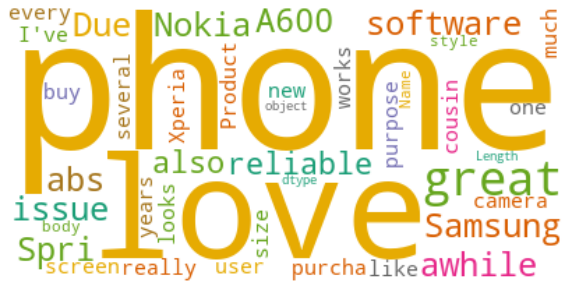

In [0]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
wc.generate(str(df_reviews.body))
plt.figure( figsize=(10,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling

In [7]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Just importing, imputing and cleaning the data again. Not required but for testing purposes

In [8]:
items_df=items.copy()
reviews_df=reviews.copy()
items_df['brand'] = np.where((items_df.asin == 'B0000SX2UC'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B01EWKHIAI'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07JHXX5YR'),'ASUS',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07T3KMJW8'),'Xiaomi',items_df.brand)
merged_data=pd.merge (items_df,reviews_df,how='left',on='asin')
merged_data.shape

(67986, 17)

In [0]:
merged_data=merged_data.rename(columns={'rating_x': 'Average_Rating','rating_y':'Customer_Rating','title_x':'Product_Name','title_y':'Review_title'})

## Cleaning using NLTK

Need to clean the reviews - lower case,remove punctuations and keywords like brand name, phone and finally lemmatize

In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer("english")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
keywords = merged_data["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [17]:
keywords

['nokia',
 'motorola',
 'samsung',
 'huawei',
 'sony',
 'apple',
 'google',
 'asus',
 'oneplus',
 'xiaomi',
 'phone',
 'iphone']

In [0]:
merged_data["body"] = merged_data["body"].astype("str")
merged_data["clean_text"] = merged_data["body"].apply(clean_text)
merged_data["positivity"] = merged_data["Customer_Rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

Creating an Apple only dataset

In [0]:
merged_data["clean_text"].head().values
apple = merged_data[merged_data["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
apple["renewed"] = apple["Product_Name"].apply(lambda x: ("Renewed" in x) | ("Refurbished" in x))

In [20]:
apple[apple['renewed']==True]
#apple.shape

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity,renewed
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1,True
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1,True
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1,True
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37581,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Greg,5,"April 1, 2019",True,Seems like a great buy,I bought this for my daughter and she seems ve...,NaN,bought daughter pleased use ting service super...,1,True
37616,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Michelle elder,4,"April 1, 2019",True,Gets hot easy.. Kinda worried and honna keep a...,Works with safelink wireless. Put in sim card ...,NaN,work safelink wireless sim card old worked im...,1,True
31785,B06XRJQX91,Apple,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ...",https://www.amazon.com/Apple-iPhone-Unlocked-D...,https://m.media-amazon.com/images/I/61+mrwyL24...,3.6,https://www.amazon.com/product-reviews/B06XRJQX91,427,158.88,271.84,Insiya Hasan,3,"April 1, 2018",True,Three Stars,The phone did have scratches and a dent on it ...,2.0,scratch dent tends overheat,0,True
42977,B077XM1GZM,Apple,"Apple iPhone 6S Plus, 64GB, Silver - Fully Unl...",https://www.amazon.com/Apple-iPhone-a1687-Unlo...,https://m.media-amazon.com/images/I/81ia5dHUn3...,3.8,https://www.amazon.com/product-reviews/B077XM1GZM,12,258.80,349.99,Cheesey,5,"April 1, 2018",True,Quality,Quality refurbished phone. Looks and works lik...,5.0,quality refurbished look work like brand new f...,1,True


In [21]:
clean_text('Fuck that was good!')

'fuck good'

In [22]:
clean_text('No no thats not how you clean. Delete it')

'thats clean delete'

## Ngrams and Wordclouds


In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(apple["clean_text"], 10)
for word, freq in common_words:
    print(word, freq)



brand new 366
battery life 359
like new 318
sim card 214
work great 176
screen protector 150
perfect condition 117
look like 111
battery health 100
good condition 92


In [0]:
df4 = pd.DataFrame(common_words, columns = ['Bigrams' , 'count'])
df4.head()

,Bigrams,count
0,brand new,366
1,battery life,359
2,like new,318
3,sim card,214
4,work great,176


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

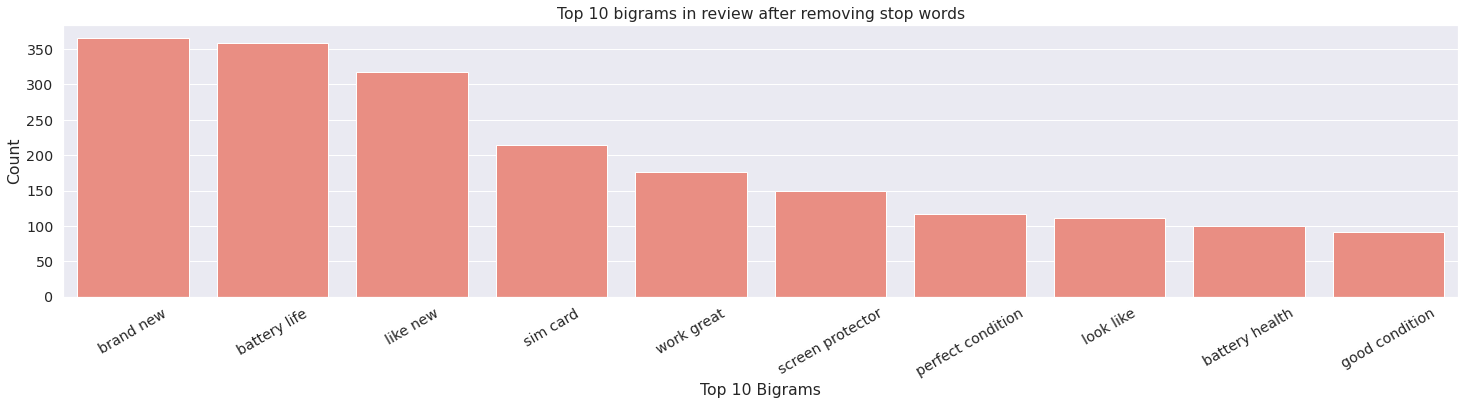

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Bigrams',y='count',data=df4,color="salmon")
plt.xlabel('Top 10 Bigrams')
plt.ylabel('Count')
plt.title('Top 10 bigrams in review after removing stop words')
plt.xticks(rotation=30);


In [0]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigrams = get_top_n_trigram(apple["clean_text"], 10)
for word, freq in common_words_trigrams:
    print(word, freq)

df5 = pd.DataFrame(common_words_trigrams, columns = ['Trigrams' , 'count'])
df5.head()

like brand new 84
look brand new 83
look like new 61
work like new 57
looked brand new 37
came screen protector 35
like new condition 26
brand new scratch 23
came perfect condition 23
glass screen protector 21


,Trigrams,count
0,like brand new,84
1,look brand new,83
2,look like new,61
3,work like new,57
4,looked brand new,37


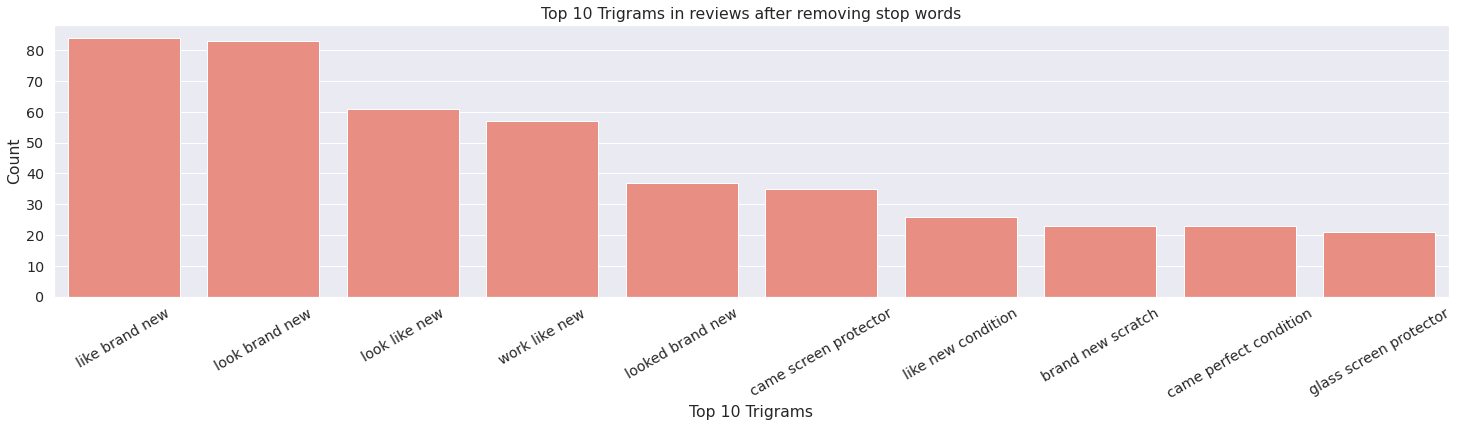

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Trigrams',y='count',data=df5,color="salmon")
plt.xlabel('Top 10 Trigrams')
plt.ylabel('Count')
plt.title('Top 10 Trigrams in reviews after removing stop words')
plt.xticks(rotation=30);

In [0]:
from wordcloud import WordCloud, ImageColorGenerator

# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [0]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

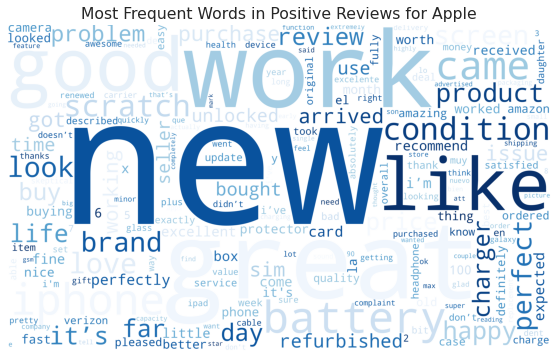

In [0]:
apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in Positive Reviews for Apple")

In [23]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
sid=SentimentIntensityAnalyzer()

In [0]:
a='yes no'

In [29]:
sid.polarity_scores(a)

{'compound': 0.128, 'neg': 0.449, 'neu': 0.0, 'pos': 0.551}

In [0]:
apple['polarity']=apple['body'].apply(lambda review:sid.polarity_scores(review))
apple['compound_polarity']=apple['polarity'].apply(lambda x:x['compound'])

In [34]:
apple.head()

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity,renewed,polarity,compound_polarity
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1,True,"{'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'comp...",0.2023
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True,"{'neg': 0.086, 'neu': 0.584, 'pos': 0.33, 'com...",0.7418
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1,True,"{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...",-0.7184
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True,"{'neg': 0.086, 'neu': 0.584, 'pos': 0.33, 'com...",0.7418


In [1]:
apple_neg = " ".join(apple[apple["positivity"]==-1]["clean_text"])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="RdBu",
                      background_color="white")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in Negative Reviews for Apple")

NameError: ignored

# LDA - Latent Dirichlet Allocation

In [0]:
#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(max_df=0.95,min_df=0.05,stop_words='english')
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05, stop_words="english")

In [0]:
#dtm = cv.fit_transform(apple['clean_text'])
dtm = tfidf_vectorizer.fit_transform(apple["clean_text"])

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=100, 
                                learning_method='online',
                                learning_offset=100.0,
                                n_jobs=1,
                                random_state=0,learning_decay=0.5)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=100.0,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=10, n_jobs=1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [0]:
single_topic=LDA.components_[0]   #len(LDA.components_)=10 , 10 topics
top_ten_words=single_topic.argsort()[-10:]
for index in top_ten_words:
  print(tfidf_vectorizer.get_feature_names()[index])
  #print(cv.get_feature_names()[index])

battery
new
good
day
screen
scratch
charger
came
product
work


In [0]:
for i,topic in enumerate(LDA.components_):
  print(f"THE TOP 10 WORDS FOR TOPIC #{i}")
  print([tfidf_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])
  #print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['battery', 'new', 'good', 'day', 'screen', 'scratch', 'charger', 'came', 'product', 'work']
THE TOP 10 WORDS FOR TOPIC #1
['condition', 'scratch', 'product', 'good', 'great', 'problem', 'issue', 'day', 'far', 'working']
THE TOP 10 WORDS FOR TOPIC #2
['issue', 'use', 'product', 'look', 'price', 'review', 'condition', 'work', 'time', 'great']
THE TOP 10 WORDS FOR TOPIC #3
['scratch', 'day', 'iphone', 'like', 'battery', 'review', 'new', 'seller', 'purchase', 'happy']
THE TOP 10 WORDS FOR TOPIC #4
['time', 'day', 'use', 'work', 'battery', 'scratch', 'issue', 'problem', 'screen', 'iphone']
THE TOP 10 WORDS FOR TOPIC #5
['bought', 'condition', 'great', 'iphone', 'brand', 'work', 'look', 'new', 'love', 'like']
THE TOP 10 WORDS FOR TOPIC #6
['look', 'charger', 'battery', 'like', 'came', 'brand', 'new', 'scratch', 'price', 'got']
THE TOP 10 WORDS FOR TOPIC #7
['iphone', 'screen', 'new', 'product', 'day', 'use', 'battery', 'refurbished', 'bought', 'buy']
THE TOP 10

In [0]:
topic_results=LDA.transform(dtm)
apple['Topic']=topic_results.argmax(axis=1)
apple.head()

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity,Topic
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1,0
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1,0
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,5
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1,9
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,5


# Ratings Prediction from reviews

In [0]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])
X = apple['clean_text']
y = apple['Customer_Rating']
review_trainLR, review_testLR, label_trainLR, label_testLR = train_test_split(X, y, test_size=0.3, random_state=101)
pipeline.fit(review_trainLR, label_trainLR)
pipe_predictedLR = pipeline.predict(review_testLR)
print(metrics.classification_report(label_testLR,pipe_predictedLR))
scores_LR = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5,scoring=('r2', 'neg_mean_squared_error'))
#print(scores_LR['test_score'].mean())
print(scores_LR['test_r2'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.52      0.30      0.38       357
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00       176
           5       0.60      0.95      0.73       849

    accuracy                           0.59      1544
   macro avg       0.22      0.25      0.22      1544
weighted avg       0.45      0.59      0.49      1544

-0.4473772842462781


Naive Bayes Model

In [0]:
#Multinomial Naive Bayes 
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', MultinomialNB())
])
X2 = apple['clean_text']
y2 = apple['Customer_Rating']
review_train2, review_test2, label_train2, label_test2 = train_test_split(X2, y2, test_size=0.3)
pipeline.fit(review_train2, label_train2)
pip_pred2 = pipeline.predict(review_test2)
print(metrics.classification_report(label_test2, pip_pred2))
scores_NB = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_NB['test_score'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.01      0.01       335
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        99
           4       0.00      0.00      0.00       158
           5       0.57      1.00      0.73       882

    accuracy                           0.57      1544
   macro avg       0.31      0.20      0.15      1544
weighted avg       0.54      0.57      0.42      1544

0.5533527696793004


Random Forest model

In [0]:
# RandomForest
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', RandomForestClassifier())])
X3 = apple['clean_text']
y3 = apple['Customer_Rating']
review_trainRF, review_testRF, label_trainRF, label_testRF = train_test_split(X3, y3, test_size=0.3)
pipeline.fit(review_trainRF, label_trainRF)
pipeline_predictedRF= pipeline.predict(review_testRF)
print(metrics.classification_report(label_testRF, pipeline_predictedRF))
scores_RF = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_RF['test_score'].mean())

              precision    recall  f1-score   support

           1       0.67      0.41      0.51       356
           2       1.00      0.12      0.22        80
           3       1.00      0.16      0.28        94
           4       0.77      0.15      0.25       154
           5       0.65      0.96      0.78       860

    accuracy                           0.66      1544
   macro avg       0.82      0.36      0.41      1544
weighted avg       0.71      0.66      0.60      1544

0.5968901846452866
